# Text Summarization  
Text summarization is the process of distilling the most important information from a source (or sources) to produce an abridged version or summary.  
<img src="img/text_sum.png" alt="Markdown Monster icon" style="float: center; margin-right: 10px;" />  

The objective of this project is to build a model that can create relevant summaries for reviews written on Wine reviews. This dataset contains above 130k reviews, and is hosted on [Kaggle](https://www.kaggle.com/zynicide/wine-reviews)  


### Types of Text Summarization Methods  
Text summarization methods can be classified into different types  
<img src="img/text_sum_types.png" alt="Markdown Monster icon" style="float: center; margin-right: 10px;" />  

i. Based on input type:  

    Single Document, where the input length is short. Many of the early summarization systems dealt with single document summarization.
    Multi Document, where the input can be arbitrarily long.  

ii. Based on the purpose:  

    Generic, where the model makes no assumptions about the domain or content of the text to be summarized and treats all inputs as homogeneous. The majority of the work that has been done revolves around generic summarization.  
    Domain-specific, where the model uses domain-specific knowledge to form a more accurate summary. For example, summarizing research papers of a specific domain, biomedical documents, etc.  
    Query-based, where the summary only contains information which answers natural language questions about the input text.  

iii. Based on output type:  

    Extractive, where important sentences are selected from the input text to form a summary. Most summarization approaches today are extractive in nature.  
    Abstractive, where the model forms its own phrases and sentences to offer a more coherent summary, like what a human would generate. This approach is definitely a more appealing, but much more difficult than extractive summarization.  


## Text summerization

In [48]:
import numpy as np # linear algebra
import spacy
nlp = spacy.load('en_core_web_sm')

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import string
import re
from collections import Counter
from time import time
import heapq

# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

#stopwords = stopwords.words('english')
sns.set_context('notebook')

In [37]:
# import dataset

path = '/Users/ndah/NEC/aims_nlp/wine_review/'
data = pd.read_csv(path + "winemag-data_first150k.csv", nrows=5000, usecols =['points', 'description'], encoding='utf-8')
data = data.dropna()
data.head(15)

,description,points
0,This tremendous 100% varietal wine hails from ...,96
1,"Ripe aromas of fig, blackberry and cassis are ...",96
2,Mac Watson honors the memory of a wine once ma...,96
3,"This spent 20 months in 30% new French oak, an...",96
4,"This is the top wine from La Bégude, named aft...",95
5,"Deep, dense and pure from the opening bell, th...",95
6,Slightly gritty black-fruit aromas include a s...,95
7,Lush cedary black-fruit aromas are luxe and of...,95
8,This re-named vineyard was formerly bottled as...,95
9,The producer sources from two blocks of the vi...,95


### Text preprocessing

In [38]:
nlp = spacy.load('en_core_web_md')

# in this step we are going to remove code syntax from text 
def normalize_text(text):
    
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>©', '', tm1, flags=re.DOTALL)
    
    return tm3.replace("\n", "")

In [39]:
data['description_cleaned_1'] = data['description'].map(lambda x: normalize_text(x))

In [41]:
n = 3
print('Before normalizing text-----\n')
print(data['description'][n])
print('\nAfter normalizing text-----\n')
print(data['description_cleaned_1'][n])

Before normalizing text-----

This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.

After normalizing text-----

This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.


In [46]:
# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~©'

def cleanup_text(docs, logging=False):
    
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)


In [47]:
data['description_cleaned'] = data['description_cleaned_1'].apply(lambda x: cleanup_text(x, False))

In [8]:
print('Reviews description with punctuatin and stopwords---\n')
print(data['description_cleaned_1'][0])
print('\nReviews description after removing punctuation and stopwrods---\n')
print(data['description_cleaned'][0])

Reviews description with punctuatin and stopwords---

This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022â2030.

Reviews description after removing punctuation and stopwrods---

tremendous 100 varietal wine hail oakville age three year oak . juicy red cherry fruit compelling hint caramel greet palate frame elegant fine tannin subtle minty tone background . balanced rewarding start finish year ahead develop nuance . enjoy 2022â2030 .


In [9]:
# plt.subplot(1, 2, 1)
# (data['points']).plot.hist(bins=30, figsize=(10,4), edgecolor='white',range=[0,150])
# plt.xlabel('Number of points', fontsize=17)
# plt.ylabel('frequency', fontsize=17)
# plt.tick_params(labelsize=15)
# plt.title('Number of points description', fontsize=17)
# plt.show()

### Analyze reviews description lengths

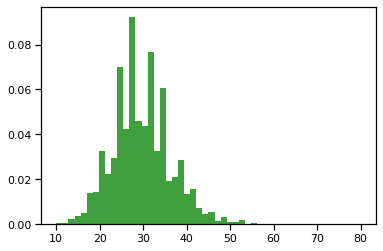

In [10]:
review_lens = data['description_cleaned'].map(lambda x: len(x.split()))
n, bins, patches = plt.hist(review_lens, 50, density=True, facecolor='g', alpha=0.75)

## Summarizer using Spacy

1. Convert Paragraphs to Sentences: We first need to convert the whole paragraph into sentences. The most common way of converting paragraphs to sentences is to split the paragraph whenever a period is encountered.

2. Text Preprocessing: After converting paragraph to sentences, we need to remove all the special characters, stop words and numbers from all the sentences.

3. Tokenizing the Sentences: We need to tokenize all the sentences to get all the words that exist in the sentences

4. Find Weighted Frequency of Occurrence: Next we need to find the weighted frequency of occurrences of all the words. We can find the weighted frequency of each word by dividing its frequency by the frequency of the most occurring word.

5. Replace Words by Weighted Frequency in Original Sentences: The final step is to plug the weighted frequency in place of the corresponding words in original sentences and finding their sum. It is important to mention that weighted frequency for the words removed during preprocessing (stop words, punctuation, digits etc.) will be zero and therefore is not required to be added

6. Sort Sentences in Descending Order of Sum: The final step is to sort the sentences in inverse order of their sum. The sentences with highest frequencies summarize the text.

In [11]:
def generate_summary(text_without_removing_dot, cleaned_text):
    
    sample_text = text_without_removing_dot
    doc = nlp(sample_text)
    sentence_list=[]
    for idx, sentence in enumerate(doc.sents): # we are using spacy for sentence tokenization
        sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))

    stopwords = nltk.corpus.stopwords.words('english')

    word_frequencies = {}  
    for word in nltk.word_tokenize(cleaned_text):  
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1

    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

    sentence_scores = {}  
    for sent in sentence_list:  
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]


    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)
    print("Original Text:\n")
    print(text_without_removing_dot)
    print('\n\nSummarized text:\n')
    print(summary)

In [12]:
generate_summary(data['description_cleaned_1'][8], data['description_cleaned'][8])

Original Text:

This re-named vineyard was formerly bottled as deLancellotti. You'll find striking minerality underscoring chunky black fruits. Accents of citrus and graphite comingle, with exceptional midpalate concentration. This is a wine to cellar, though it is already quite enjoyable. Drink now through 2030.


Summarized text:

Accents of citrus and graphite comingle with exceptional midpalate concentration This is a wine to cellar though it is already quite enjoyable Youll find striking minerality underscoring chunky black fruits This renamed vineyard was formerly bottled as deLancellotti Drink now through 2030


In [13]:
generate_summary(data['description_cleaned_1'][10], data['description_cleaned'][10])

Original Text:

Elegance, complexity and structure come together in this drop-dead gorgeous winethat ranks among Italy's greatest whites. It opens with sublime yellow spring flower, aromatic herb and orchard fruit scents. The creamy, delicious palate seamlessly combines juicy white peach, ripe pear and citrus flavors while white almond and savory mineral notes grace the lingering finish.


Summarized text:

The creamy delicious palate seamlessly combines juicy white peach ripe pear and citrus flavors while white almond and savory mineral notes grace the lingering finish Elegance complexity and structure come together in this dropdead gorgeous winethat ranks among Italys greatest whites It opens with sublime yellow spring flower aromatic herb and orchard fruit scents


## Text summarization using word2vec

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re

from nltk.tokenize import sent_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.models.keyedvectors as word2vec
import gc
import string

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from helper.contractions import CONTRACTION_MAP
from bs4 import BeautifulSoup

from nltk.corpus import stopwords

In [15]:
path = '/Users/ndah/NEC/aims_nlp/wine_review/'
data = pd.read_csv(path + "winemag-data_first150k.csv", nrows=8000, encoding='latin1')
data = data.dropna()
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,BergstrÃ¶m
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


#### Sentence tokenization
We can use the NLTK’s sentence tokenizer to obtain the sentence level tokens.

In [16]:
def sentence_tokenizer(text):
    """Modulke to create sentenc tokens"""
    return sent_tokenize(text, language = 'en')

In [17]:
reviews_list = data['description'].map(lambda x: sent_tokenize(x))

In [18]:
reviews_list[2]

['Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white.',
 'Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.']

#### Skip-Thought Encoder

We need a way to generate fixed length vector representations for each sentence in our reviews. These representations should encode the inherent semantics and the meaning of the corresponding sentence. The well known Skip-Gram Word2Vec method for generating word embeddings can give us word embeddings for individual words that are present in our model’s vocabulary (some [fancier approaches](https://arxiv.org/abs/1607.04606) can also generate embeddings for words which are not in the model vocabulary using subword information).  

For sentence embeddings, one easy way is to take a weighted sum of the word vectors for the words contained in the sentence. We take a weighted sum because frequently occurring words such as ‘and’, ‘to’ and ‘the’, provide little or no information about the sentence. Some rarely occurring words, which are unique to a few sentences have much more representative power. Hence, we take the weights as being inversely related to the frequency of word occurrence. This method is described in detail in this [paper](https://openreview.net/pdf?id=SyK00v5xx).

However, these unsupervised methods do not take the sequence of words in the sentence into account. This may incur undesirable losses in model performance. To overcome this, I chose to instead train a Skip-Thought sentence encoder in a supervised manner using Wikipedia dumps as training data. The Skip-Thoughts model consists of two parts:

1. Encoder Network: The encoder is typically a GRU-RNN which generates a fixed length vector representation h(i) for each sentence S(i) in the input. The encoded representation h(i) is obtained by passing final hidden state of the GRU cell (i.e. after it has seen the entire sentence) to multiple dense layers.  

2. Decoder Network: The decoder network takes this vector representation h(i) as input and tries to generate two sentences — S(i-1) and S(i+1), which could occur before and after the input sentence respectively. Separate decoders are implemented for generation of previous and next sentences, both being GRU-RNNs. The vector representation h(i) acts as the initial hidden state for the GRUs of the decoder networks.


Given a dataset containing a sequence of sentences, the decoder is expected to generate the previous and next sentences, word by word. The encoder-decoder network is trained to minimize the sentence reconstruction loss, and in doing so, the encoder learns to generate vector representations which encode enough information for the decoder, so that it can generate neighboring sentences. These learned representations are such that embeddings of semantically similar sentences are closer to each other in vector space, and therefore are suitable for clustering. The sentences in our emails are given as input to the encoder network to obtain the desired vector representations. This Skip-Thoughts approach for obtaining sentence embeddings is described in detail in this [paper](https://arxiv.org/abs/1506.06726).  

Skipthought code can be found [here](https://github.com/ryankiros/skip-thoughts) 


#### Clustering  
After generating sentence embeddings for each sentence in an review, the approach is to cluster these embeddings in high-dimensional vector space into a pre-defined number of clusters. The number of clusters will be equal to desired number of sentences in the summary. I chose the numbers of sentences in the summary to be equal to the square root of the total number of sentence in the review. One can also have it as being equal to, say, _30%_ of the total number of sentences.  

#### Summarization  
Each cluster of sentence embeddings can be interpreted as a set of semantically similar sentences whose meaning can be expressed by just one candidate sentence in the summary. The candidate sentence is chosen to be the sentence whose vector representation is closest to the cluster center. Candidate sentences corresponding to each cluster are then ordered to form a summary for a review. The order of the candidate sentences in the summary is determined by the positions of the sentences in their corresponding clusters in the original review. For example, a candidate sentence is chosen as the first line in the summary if most of the sentences that lie in its cluster occur at the beginning of the review.  

*As this method essentially extracts some candidate sentences from the text to form a summary, it is known as Extractive Sumarization*




In [19]:
embed_size = 100
EMBEDDING_FILE = '/Users/ndah/NEC/aims_nlp/glove.6B/glove.6B.100d.txt'
glove_embeddings = open(EMBEDDING_FILE, encoding="utf8")

In [20]:
embedd_dict = dict()

for embeddings in glove_embeddings:
    embedding_tokens = embeddings.split()
    emb_word = embedding_tokens[0]
    emb_vector = np.asarray(embedding_tokens[1:], dtype='float32')
    embedd_dict[emb_word] = emb_vector

glove_embeddings.close()


In [21]:
def expand_contractions(text):
    words = text.strip().split()
    words_expand = []
    for word in words:
        if word in CONTRACTION_MAP.keys():
            words_expand.append(CONTRACTION_MAP[word])
        else:
            words_expand.append(word)
            
    text_expand = ' '.join(words_expand)
    return text_expand


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    
    return stripped_text


def cleanup_text(text):
    text = expand_contractions(text)
    text = strip_html_tags(text)
    return text


def sentence_embedding(tokens, word2vec):
    """
    Naive embeddings: Calculates the embedding for entire sentence by taking the average of all words
    """
    tokens_emb =[]
    for token in tokens:
        embedding_vector = word2vec.get(token)
        if embedding_vector is not None:
            tokens_emb.append(embedding_vector)

    return np.mean(np.array(tokens_emb), axis=0)


nlp = spacy.load('en_core_web_sm')
def spacy_lemmatizer(sentence):
    spacy_sentence = nlp(sentence)
    tokens = []
    for word in spacy_sentence:
        if not word.is_stop:
            tokens.append(word.lemma_)
        
    return tokens


def embedding(sentence_tokens, word2vec):
    """Calculates the embedding of each sentence in the review"""
    sentence_enc = []
    for sentence in sentence_tokens:
        sentence_clean = cleanup_text(sentence)
        tokens = spacy_lemmatizer(sentence_clean)
        res = list(sentence_embedding(tokens, word2vec))
        
        sentence_enc.append(res)
        
    return np.array(sentence_enc)

In [22]:
def summarize(reviews, word2vec):
    """
    Performs summarization of reviews
    """
    summary = []
    
    for review in reviews:
        
        sent_tokens = sent_tokenize(review.strip())
        
        review_enc = embedding(sent_tokens, word2vec)        
        n_clusters = int(np.ceil(len(review_enc)**0.5))
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans = kmeans.fit(review_enc)
        
        avg = []
        closest = []
        for j in range(n_clusters):
            idx = np.where(kmeans.labels_ == j)[0]
            avg.append(np.mean(idx))
            
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, review_enc)
        ordering = sorted(range(n_clusters), key=lambda k: avg[k])
        review_summary = ' '.join([sent_tokens[closest[idx]] for idx in ordering])
        
        summary.append(review_summary)
        
    return summary

In [23]:
test = data.sample(n = 5)
test.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
2987,2987,US,"The color of oxblood, this meaty, tannic wine ...",Estate,89,32.0,Oregon,Rogue Valley,Southern Oregon,Syrah,Folin Cellars
4643,4643,US,"Bold, penetrating tannins and bright cranberry...",Moffett Block,88,32.0,New York,Finger Lakes,Finger Lakes,BlaufrÃ¤nkisch,Atwater
336,336,US,There's a cantaloupe-like ripeness on the nose...,XCV,91,38.0,California,Paso Robles Willow Creek District,Central Coast,RhÃ´ne-style White Blend,Jada Vineyard & Winery
687,687,US,Silky in cherry and strawberry with a dense mi...,Spire,88,48.0,California,Carneros-Napa Valley,Napa,Pinot Noir,Cuvaison
5471,5471,US,"From a particular block with limestone soils, ...",Coteau Blanc,88,45.0,California,Carneros,Napa-Sonoma,Chardonnay,Chardenet


In [24]:
descriptions = test['description'].to_list()
test_summary = summarize(test['description'].to_list(), embedd_dict)

In [25]:
for i in range(test.shape[0]):
    print("Original Text:\n")
    print(descriptions[i])
    print('\n\nSummarized text:\n')
    print(test_summary[i])
    print()

Original Text:

The color of oxblood, this meaty, tannic wine pours espresso, black licorice and composted earth around tart blackberry fruit. It's aromatic, spicy and nicely balanced.


Summarized text:

The color of oxblood, this meaty, tannic wine pours espresso, black licorice and composted earth around tart blackberry fruit. It's aromatic, spicy and nicely balanced.

Original Text:

Bold, penetrating tannins and bright cranberry acidity lend a tight frame to this classically styled BlaufrÃ¤nkisch, a.k.a. Lemberger. Crisp-tart blackberry and blueberry flavors are accented by bramble and herb notes that linger long on the finish. Its quite closed now, but should show well after 2018.


Summarized text:

Bold, penetrating tannins and bright cranberry acidity lend a tight frame to this classically styled BlaufrÃ¤nkisch, a.k.a. Its quite closed now, but should show well after 2018.

Original Text:

There's a cantaloupe-like ripeness on the nose of this blend of 37% Grenache Blanc, 33% 

As you can notice, this method for summarization fares much better when the review consists of several sentences, instead of just 2–3 sentences. For a three sentence review, the summary will consist of two sentences, which shouldn’t be the case. Also, these three sentences may be conveying entirely different things, and omitting information from any one sentence is not desirable. Extractive methods normally are not preferred for summarization of short inputs, for this very reason. Supervised Seq2Seq models are better suited for this task. However in this case, reviews are generally longer in length and extractive methods work surprisingly well.